# V0 使用 K-means 分群、cosine-similarity 判斷相似性
4. 

In [1]:
import pandas as pd
from tqdm import trange
import ast
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
import matplotlib.pyplot as plt

# from google.cloud import bigquery
# from google.cloud.exceptions import NotFound
import pandas as pd

## 載檔

In [3]:
file_full_name = "v1_Total_Opinion.csv"
# file_output_name = file_full_name.split(".csv")[0]

news_df = pd.read_csv(file_full_name)
# all_output_file = "./v0" + file_output_name + "_result.csv"
# opinion_after_cluster_file = "./v0" + file_output_name + "_all_opinions_after_cluster.csv"
all_output_file = "v1_Total_Opinion.csv"
opinion_after_cluster_file = "v1_cluster_opinions.csv"

In [4]:
# news_df = pd.read_csv(all_output_file)

In [5]:
# print(type(opinion_after_cluster_file))

In [6]:
news_df.head(1)

,id,article,category,company_id,reporter,timestamp,title,url_pattern,label,annotator,annotation_id,created_at,updated_at,lead_time,article_coref,people_name,ner,one_to_one_pair,one_to_one_pair_count,opinions_list
0,883,"針對行政院長蘇貞昌、國民黨立委鄭麗文12日在立法院發生激烈爭執,兼任民進黨主席的總統蔡英文1...",政治,3,陶本和,1634110500,蔡英文發聲挺蘇貞昌 批鄭麗文情緒性發言對當事人不公,2100273,"[{""start"": 0, ""end"": 142, ""text"": ""針對行政院長蘇貞昌、國...",1,37,2022-02-03T14:55:55.310663Z,2022-02-03T15:02:18.598120Z,518.272,"針對行政院長蘇貞昌、國民黨立委鄭麗文12日在立法院發生激烈爭執,兼任民進黨主席的總統蔡英文1...","['蔡英文', '行政院長', '鄭麗文', '民進黨', '蘇貞昌', '台灣人民', '...","['蔡英文', '行政院長', '12日', '鄭麗文', '台灣', '民進黨', '蘇貞...","[[{'start': 134, 'end': 138, 'text': '台灣人民', '...",9,"[[[{'start': 142, 'end': 145, 'text': '蔡英文', '..."


#### 輸入 ckip 帳號密碼

In [7]:
embedder = SentenceTransformer('ckiplab/bert-base-chinese')

Some weights of the model checkpoint at C:\Users\User/.cache\torch\sentence_transformers\ckiplab_bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at C:\Users\User/.cache\torch\sentence_transformers\c

## 4. 使用 K-means 並串接 Dataset
1. 使用 sentenceTransformer 套件作為 embedder
2. 找出最適合的分群群數
3. 找出每一群中，最接近中心點的句子作為代表
4. 根據 model clustered label list 分配每個句子到所屬的 clustered list 
5. 印出最終結果

參考資料  
https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/kmeans.py  
https://www.sbert.net/docs/pretrained_models.html  
https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion    
https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn  

In [8]:
def cluster_article_opinions(combine_opinions_dict):
    opinions_after_cluster  = []
    for name_key in combine_opinions_dict.keys():
        order_list = [item[2] for item in combine_opinions_dict[name_key]]
        verb_list = [item[0] for item in combine_opinions_dict[name_key]]
        corpus = [item[1] for item in combine_opinions_dict[name_key]]
        corpus_embeddings = embedder.encode(corpus)

        if len(corpus)== 1:
            # print('no cluster :')
            # print("person: ",name_key)
            # print(corpus[0])
            opinions_after_cluster.append({"person":name_key,"verb":verb_list[0],"opinion":corpus[0],"order":order_list[0]})
            continue
        elif len(corpus)== 2:
            # compare the cosine similarity if bigger than 0.8, choose shorter one
            cosine_scores = util.cos_sim(corpus_embeddings[0], corpus_embeddings[1])
            # print(corpus)
            # print(cosine_scores)
            if cosine_scores > 0.8:
                if(len(corpus_embeddings[0]) < len(corpus_embeddings[1])):
                    opinions_after_cluster.append({"person":name_key,"verb":verb_list[0],"opinion":corpus[0],"order":order_list[0]})
                else:
                    opinions_after_cluster.append({"person":name_key,"verb":verb_list[1],"opinion":corpus[1],"order":order_list[1]})
            continue
        
        # Find out the best score
        sil_coeff_list = []
        least_cluster_num = 2
        if  5 >= len(corpus) > 3:
            least_cluster_num = len(corpus) - 2
        elif  7 >= len(corpus_embeddings) > 5:
            least_cluster_num = len(corpus_embeddings) - 3
        elif len(corpus_embeddings) > 7:
            least_cluster_num = len(corpus_embeddings) - 4

        for n_cluster in range(least_cluster_num, len(corpus_embeddings)):
            clustering_model = KMeans(n_clusters=n_cluster).fit(corpus_embeddings)
            label = clustering_model.labels_
            sil_coeff = silhouette_score(corpus_embeddings, label, metric='euclidean')
            sil_coeff_list.append(sil_coeff)

        # print('least_cluster_num',least_cluster_num)
        # print('len corpus',len(corpus))
        # print('max index in coeff list',sil_coeff_list.index(max(sil_coeff_list)))


        num_clusters = sil_coeff_list.index(max(sil_coeff_list)) + least_cluster_num
        plt.plot(range(least_cluster_num,len(corpus_embeddings)), sil_coeff_list)
        # print("best clusters num: ",num_clusters)

        # Perform k-means clustering
        clustering_model = KMeans(n_clusters=num_clusters)
        clustering_model.fit(corpus_embeddings)
        cluster_label_list = clustering_model.labels_
        # print(cluster_label_list)

        # Find the closet sentence in every cluster to represent group meaning
        closest_index_list, _ = pairwise_distances_argmin_min(clustering_model.cluster_centers_, corpus_embeddings)
        # print("closest_index_list: ",closest_index_list)

        # Group all sentences into their clustered_sentences_list
        clustered_sentences_list = [[] for i in range(num_clusters)]
        for sentence_id, cluster_id in enumerate(cluster_label_list):
            clustered_sentences_list[cluster_id].append(corpus[sentence_id])

        # print out result
        # print("person: ", name_key)
        for i, clustered_sentences in enumerate(clustered_sentences_list):
            # print("Cluster ", i+1)
            # print("all sentence: ",clustered_sentences)
            # print("represent sentence:",corpus[closest_index_list[i]])
            # print("")
            opinions_after_cluster.append({"person":name_key, "verb":verb_list[closest_index_list[i]], "opinion":corpus[closest_index_list[i]], "order":order_list[closest_index_list[i]]})
    
    return opinions_after_cluster
        


In [9]:
def remove_duplicate_same_article_sentence(article_opinions):
    sentences = [opinion_object['opinion'] for opinion_object in article_opinions]
    paraphrases = util.paraphrase_mining(embedder, sentences)
    for paraphrase in paraphrases:
        score, i, j = paraphrase
        if score > 0.95:
            # print("{} \n {} \n Score: {:.4f}\n\n".format(sentences[i], sentences[j], score))
            if len(sentences[i]) <= len(sentences[j]):
                article_opinions[i] = ""
            else:
                article_opinions[j] = ""
    article_opinions = [x for x in article_opinions if x]

    return article_opinions


## 5. 開始實作

### 4.

  5%|▌         | 5/100 [00:03<01:11,  1.33it/s]

5


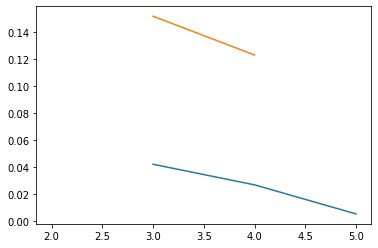

In [10]:
all_opinions_after_cluster = []
for i in trange(len(news_df)):
    if i == 5 :
        break
    # print('-'*200,'\narticle: ',i)
    # try:
    #     name_list = ast.literal_eval(news_df.iloc[i]['people_name'])
    # except:
    #     name_list = []
    # print(name_list)
    # print('name list',news_df.iloc[i]['people_name'])
    opinions_list = ast.literal_eval(news_df.iloc[i]["opinions_list"])
    combine_opinions_dict = {}
    for opinions in opinions_list:
        order = opinions[1]
        for opinion_item_dict in opinions[0]:
            if opinion_item_dict['labels'][0] == 'person':
                person_name = opinion_item_dict['text']
            elif opinion_item_dict['labels'][0] == 'verb':
                verb_words = opinion_item_dict['text']
            elif opinion_item_dict['labels'][0] == 'opinion':
                opinion_words = opinion_item_dict['text']
        # the opinions in reasonable count
        if 10 < len(opinion_words) < 150: #  and opinions['person'] in name_list
            if person_name in combine_opinions_dict.keys():
                combine_opinions_dict[person_name].append([verb_words,opinion_words,order])
            else:
                combine_opinions_dict[person_name] = []
                combine_opinions_dict[person_name].append([verb_words,opinion_words,order])
    # print(combine_opinions_dict)
    opinions_after_cluster = cluster_article_opinions(combine_opinions_dict)
    # print(i, opinions_after_cluster)
    # print()
    all_opinions_after_cluster.append(opinions_after_cluster)
    # print()
        # print(opinions['person'], opinions['verb'],":", opinions['opinion'])
print(len(all_opinions_after_cluster))

In [11]:
for i in trange(len(all_opinions_after_cluster)):
    try:
        all_opinions_after_cluster[i] = remove_duplicate_same_article_sentence(all_opinions_after_cluster[i])
    except:
        pass

100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


In [12]:
# for i,opinions_list in enumerate(all_opinions_after_cluster):
#     print('-'*100)
#     print(i)
#     for opinions in opinions_list:
#         print(opinions['person'], opinions['verb'],":", opinions['opinion'])

In [13]:
s = pd.Series(all_opinions_after_cluster,name='all_opinions_after_cluster')
new_cluster_opinions = pd.concat([news_df['title'],news_df['article'], s], axis=1)

In [17]:
new_cluster_opinions.head(5)

,title,article,all_opinions_after_cluster
0,蔡英文發聲挺蘇貞昌 批鄭麗文情緒性發言對當事人不公,"針對行政院長蘇貞昌、國民黨立委鄭麗文12日在立法院發生激烈爭執,兼任民進黨主席的總統蔡英文1...","[{'person': '蔡英文', 'verb': '重申', 'opinion': '台..."
1,蘇貞昌酸鄭麗文「民進黨叛徒」 他反譏:蔡英文也當國民黨閣員,"行政院長蘇貞昌12日在立法院總質詢時,怒斥國民黨立委鄭麗文「袂見笑」、「當時還要拜託我去幫你...","[{'person': '費鴻泰', 'verb': '說', 'opinion': '「如..."
2,蔡其昌質疑「想買中國科興疫苗」 國民黨團今按鈴控告妨害名譽,"台灣基進立委陳柏惟遭罷免團體掛看板質疑「反對採購疫苗」,立法院副院長蔡其昌4日反駁,陳柏惟反...","[{'person': '陳柏惟', 'verb': '質疑', 'opinion': '「..."
3,丁特控「天堂M」製作機率造假 高虹安揪朝野立委推「轉蛋法」修法,"實況主丁特日前因質疑「天堂M」遊戲道具製作機率公告不實,引起各界關注。民眾黨立委高虹安14日...","[{'person': '高虹安', 'verb': '表示', 'opinion': '今..."
4,全民防衛動員署明年成立 全動室主任韓岡明屆齡退休,"國防部長邱國正14日證實,長年從事後備動員業務規劃的國防部全民防衛動員綜合作業室主任韓岡明,...","[{'person': '國防部', 'verb': '證實', 'opinion': '長..."


In [15]:
new_cluster_opinions.to_csv(opinion_after_cluster_file,index=False) 